# Evolutionary computing: lab2

The aim of lab is to learn a reinforcement learning agent to play simple GYM environment (LunarLander-v2). The agent is a neural network that takes as input current state of a game and outputs probabilities for actions. (https://gym.openai.com/).

You have a pattern script with main structure of algorithm, but you have to repair it or change it completely, as you wish. You can change current mutation, crossover, selection, evolution scheme or even use another algorithm as PSO.  To use LunarLander, you need to uncomment config for it, because by default it is stand for CartPole environment.

As for LunarLander, the agent receives following rewards: -0.1 for each time you launch the engine, -100 for broke and +200 for successful landing. Therefore, good results starts from +100 approximately.

Please, work with this script and try to learn the agent how to play and achieve good scores. Lets say about restriction:
max_pop_size = 20;
maximum_iterations = 200.

Libraries installing

In [1]:
!pip install deap

     |████████████████████████████████| 160 kB 21.5 MB/s 


In [2]:
!pip3 install box2d-py

     |████████████████████████████████| 448 kB 37.7 MB/s 


In [3]:
!pip3 install gym[Box_2D]

In [4]:
from deap import tools, base, creator
import numpy as np
import numpy.random as rnd
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, InputLayer
import gym
from copy import deepcopy
import matplotlib.pyplot as plt
import random

Functions for logging

In [5]:
def read_log(log):
    avg_list = list()
    std_list = list()
    min_list = list()
    max_list = list()
    gen_list = list()
    for g in log:
        avg_list.append(g['avg'])
        std_list.append(g['std'])
        min_list.append(g['min'])
        max_list.append(g['max'])
        gen_list.append(g['gen'])
    return np.array(gen_list), np.array(avg_list), np.array(std_list), np.array(max_list), np.array(min_list)

def draw_log(log):
    gen_list, avg_list, std_list, max_list, min_list = read_log(log)
    plt.plot(gen_list, avg_list, label="avg")
    plt.plot(gen_list, min_list, label="min")
    plt.plot(gen_list, max_list, label="max")
    plt.fill_between(gen_list, avg_list-std_list, avg_list+std_list, alpha=0.2)
    plt.legend()
    plt.tight_layout()
    plt.show()

def draw_logs(log1, log2, lab1, lab2):
    gen1, avg1, std1, max1, min1 = read_log(log1)
    gen2, avg2, std2, max2, min2 = read_log(log2)
    plt.plot(gen1, avg1, label=lab1, color="blue")
    plt.plot(gen1, max1, label="{}_max".format(lab1), color="blue", linewidth=2)
    plt.fill_between(gen1, avg1 - std1, avg1 + std1, alpha=0.2, color="blue")
    plt.plot(gen2, avg2, label=lab2, color="orange")
    plt.plot(gen2, max2, label="{}_max".format(lab2), color="orange", linewidth=2)
    plt.fill_between(gen2, avg2 - std2, avg2 + std2, alpha=0.2, color="orange")
    plt.legend()
    plt.tight_layout()
    plt.show()


Here we describe eaMuPlusLambda algorithm (mu - population size, lambda - number of individuals after crossover, the next generation is formed both from new individuals and old ones

In [21]:
def varOr(population, toolbox, lambda_, cxpb, mutpb):
    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = list(map(toolbox.clone, random.sample(population, 2)))
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            del ind2.fitness.values
            offspring.append(ind1)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(toolbox.clone(random.choice(population)))

    return offspring


def eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Vary the population
        if halloffame is not None:
            for ind in halloffame:
                population.append(toolbox.clone(ind))
        offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)

    return population, logbook


# Reinforcement Learning Experiment

In [7]:
class RL_ga_experiment:
    def factory(self):
        individual = list()
        for i in range(len(self.params)):
            if i % 2 == 0:
                individual.append(rnd.normal(0.1, 0.3, size=self.params[i].shape))
            else:
                individual.append(np.zeros(shape=self.params[i].shape))
        return creator.Individual(individual)

    def mutation(self, individual):
        for i in range(len(individual)):
            if i % 2 == 0:
                for j in range(len(individual[i])):
                    for k in range(len(individual[i][j])):
                        if rnd.random() < 0.15:
                            individual[i][j] += rnd.normal(0.0, 0.2)

        return individual,


    def crossover(self, p1, p2):

        c1 = list()
        c2 = list()

        c1.append(deepcopy(p1[0]))
        c1.append(deepcopy(p1[1])) # zero
        c1.append(deepcopy(p2[2]))
        c1.append(deepcopy(p1[3])) # zero
        c1.append(deepcopy(p1[4]))
        c1.append(deepcopy(p1[5])) # zero

        c2.append(deepcopy(p2[0]))
        c2.append(deepcopy(p2[1]))  # zero
        c2.append(deepcopy(p1[2]))
        c2.append(deepcopy(p2[3]))  # zero
        c2.append(deepcopy(p2[4]))
        c2.append(deepcopy(p2[5]))  # zero

        return creator.Individual(c1), creator.Individual(c2)

    def __init__(self, input_dim, l1, l2, output_dim, pop_size, iterations):
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.l1 = l1
        self.l2 = l2
        self.pop_size = pop_size
        self.iterations = iterations

        self.model = self.build_model()
        self.params = self.model.get_weights()

        self.mut_prob = 0.4
        self.cxpb = 0.4
        #self.env = gym.make("CartPole-v0")
        # todo uncomment for LunarLander
        self.env = gym.make("LunarLander-v2")

        self.engine = base.Toolbox()
        self.engine.register('map', map)
        self.engine.register("individual", tools.initIterate, creator.Individual, self.factory)
        self.engine.register('population', tools.initRepeat, list, self.engine.individual, self.pop_size)
        self.engine.register('mutate', self.mutation)
        self.engine.register("mate", self.crossover)
        self.engine.register('select', tools.selTournament, tournsize=3)
        self.engine.register('evaluate', self.fitness)
        self.render = False

        self.best_fit = None

    def compare(self, ind1, ind2):
        result = True
        for i in range(len(ind1)):
            if i % 2 == 0:
                for j in range(len(ind1[i])):
                    for k in range(len(ind1[i][j])):
                        if ind1[i][j][k] != ind2[i][j][k]:
                            return False

        return result

    def run(self, update_log = 'yes'):
        pop = self.engine.population()
        hof = tools.HallOfFame(3, similar=self.compare)
        stats = tools.Statistics(lambda ind: ind.fitness.values[0])
        stats.register('min', np.min)
        stats.register('max', np.max)
        stats.register('avg', np.mean)
        stats.register('std', np.std)

        pop, log = eaMuPlusLambda(pop, self.engine, mu=self.pop_size, lambda_=int(0.8 * self.pop_size), cxpb=self.cxpb, mutpb=self.mut_prob,
                                  ngen=self.iterations, halloffame=hof, stats=stats, verbose=True if update_log == 'yes' else False)
        best = hof[0]
        if update_log == 'yes':
          print("Best fitness = {}".format(best.fitness.values[0]))
        self.best_fit = hof[0].fitness.values[0]
        return log, best


    def build_model(self):
        model = Sequential()
        model.add(InputLayer(self.input_dim))
        model.add(Dense(self.l1, activation='relu'))
        model.add(Dense(self.l2, activation='relu'))
        model.add(Dense(self.output_dim, activation='softmax'))
        model.compile(optimizer='adam', loss='mse')
        return model

    def fitness(self, individual):
        self.model.set_weights(individual)
        scores = []
        for _ in range(1):
            state = self.env.reset()
            score = 0.0
            for t in range(200):
                if self.render:
                    self.env.render()
                act_prob = self.model.predict(state.reshape(1, self.input_dim)).squeeze()
                action = rnd.choice(np.arange(self.output_dim), 1, p=act_prob)[0]
                next_state, reward, done, _ = self.env.step(action)
                score += reward
                state = next_state
                if done:
                    break
            scores.append(score)
        return np.mean(scores),

In [8]:
creator.create("BaseFitness", base.Fitness, weights=(1.0, ))
creator.create("Individual", list, fitness=creator.BaseFitness)

In [11]:
#max_pop_size = 20
#maximum_iterations = 200
# config for Lunar Lander
input_dim = 8
l1 = 64
l2 = 16
output_dim = 4

pop_size = 10
iterations = 10

In [ ]:
exp = RL_ga_experiment(input_dim, l1, l2, output_dim, pop_size, iterations)
exp.render = False

In [ ]:
log, best = exp.run()

gen	nevals	min     	max     	avg     	std    
0  	10    	-875.711	-97.8534	-453.603	231.764
1  	8     	-676.192	-139.998	-313.718	144.014
2  	4     	-338.59 	-97.8534	-153.977	75.2596
3  	6     	-139.998	-97.8534	-118.789	18.4752
4  	7     	-138.852	-97.8534	-108.586	14.1258
5  	7     	-119.962	-91.1058	-101.878	8.08937
6  	6     	-97.8534	-91.1058	-93.1301	3.09216
7  	6     	-97.8534	-91.1058	-92.4553	2.69906
8  	5     	-97.8534	-91.1058	-92.0721	2.02822
9  	8     	-122.792	-61.8822	-92.3611	13.9432
10 	7     	-95.3347	-61.8822	-83.2713	14.0883
Best fitness = -61.882152145930746


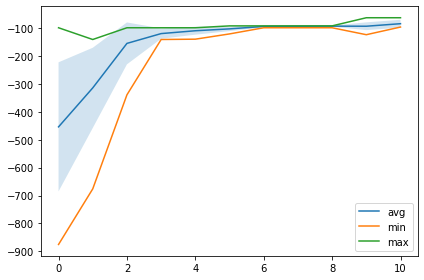

In [ ]:
draw_log(log)

For LunarLander, the agent receives following rewards: -0.1 for each time you launch the engine, -100 for broke and +200 for successful landing. 

Default results are not so good, we can see that best fitness is still negative. Let's try to change some features of evolution algorithm:

Changing of crossover function: add more random features intersection

In [ ]:
def new_crossover(p1, p2):

        c1 = list()
        c2 = list()

        # generate n (n<=len(p1)) different numbers from 0 to len(n)
        n = rnd.randint(0, len(p1) + 1)
        mas = list()
        for i in range(n):
          candidat = rnd.randint(0, len(p1))
          while candidat in mas:
            candidat = rnd.randint(0, len(p1))
          mas.append(candidat)

        # for c1 one chooses feature i from p1 only of if mas contains i 
        for i in range(0, len(p1)):
          if i in mas:
            c1.append(deepcopy(p1[i]))
            c2.append(deepcopy(p2[i]))
          else:
            c1.append(deepcopy(p2[i]))
            c2.append(deepcopy(p1[i]))

        return creator.Individual(c1), creator.Individual(c2)

In [ ]:
exp.engine.register("mate", new_crossover)
log, best = exp.run()

gen	nevals	min     	max     	avg     	std    
0  	10    	-1243.42	-101.551	-458.018	323.485
1  	8     	-312.028	-3.61899	-117.744	72.1884
2  	8     	-101.551	-3.61899	-91.7574	29.3795
3  	8     	-101.551	-3.61899	-72.1711	44.8779
4  	8     	-101.551	-3.61899	-48.2372	45.2492
5  	8     	-101.551	-3.61899	-19.7101	33.1176
6  	8     	-101.551	-3.61899	-13.4122	29.3795
7  	8     	-99.2988	-3.61899	-22.3574	37.4875
8  	8     	-95.3237	-3.61899	-12.7895	27.5114
9  	8     	-3.61899	-3.61899	-3.61899	0      
10 	8     	-3.61899	17.111  	-0.580864	6.56184
Best fitness = 17.111009651568466


Result seem to be a little bit better, but let's continue to change different aspects:

Selection experiments

In [ ]:
exp.engine.register('select', tools.selTournament, tournsize=5)

In [ ]:
log, best = exp.run()

gen	nevals	min     	max     	avg     	std    
0  	10    	-775.812	-73.6261	-325.387	225.599
1  	8     	-272.184	-73.6261	-109.883	58.1898
2  	3     	-78.2396	-73.6261	-75.0101	2.1142 
3  	7     	-73.6261	58.4875 	-37.363 	49.9977
4  	8     	-73.6261	58.4875 	-9.77067	56.7896
5  	5     	-52.7962	58.4875 	17.9911 	49.7332
6  	6     	58.4875 	58.4875 	58.4875 	7.10543e-15
7  	8     	-52.7962	58.4875 	47.3591 	33.3851    
8  	7     	58.4875 	58.4875 	58.4875 	7.10543e-15
9  	7     	58.4875 	58.4875 	58.4875 	7.10543e-15
10 	6     	58.4875 	58.4875 	58.4875 	7.10543e-15
Best fitness = 58.48747529138379


In [ ]:
exp.engine.register('select', tools.selRoulette)

In [ ]:
log, best = exp.run()

gen	nevals	min     	max     	avg     	std    
0  	10    	-488.101	-120.785	-282.926	108.339
1  	7     	-107.457	-107.457	-107.457	1.42109e-14
2  	6     	-101.686	-101.686	-101.686	1.42109e-14
3  	5     	-92.0665	-92.0665	-92.0665	0          
4  	6     	-22.9746	-22.9746	-22.9746	0          
5  	7     	-19.2478	-19.2478	-19.2478	3.55271e-15
6  	7     	-19.2478	-19.2478	-19.2478	3.55271e-15
7  	5     	-19.2478	-19.2478	-19.2478	3.55271e-15
8  	7     	-19.2478	-19.2478	-19.2478	3.55271e-15
9  	8     	-19.2478	-19.2478	-19.2478	3.55271e-15
10 	6     	-19.2478	-19.2478	-19.2478	3.55271e-15
Best fitness = -19.24784116845906


We can see that tournament with size 5 works better then Roullette

Mutation experiments

In [ ]:
# let's set self.mut_prob
exp.mut_prob = 0.7
log, best = exp.run()

gen	nevals	min     	max     	avg     	std    
0  	10    	-643.423	-92.0022	-368.347	159.868
1  	8     	-467.155	-92.0022	-176.886	115.336
2  	8     	-163.324	-92.0022	-107.379	24.8992
3  	8     	-92.0022	-26.012 	-78.8042	26.3961
4  	8     	-92.0022	-26.012 	-78.8042	26.3961
5  	8     	-92.0022	-9.37824	-49.227 	32.2774
6  	8     	-92.0022	-9.37824	-31.7977	29.219 
7  	8     	-155.668	-9.37824	-30.6607	42.4005
8  	8     	-84.4139	10.6022 	-18.2105	24.0891
9  	8     	-84.4139	10.6022 	-8.88965	26.879 
10 	8     	-112.397	10.6022 	-9.6899 	35.5077
Best fitness = 10.602154806188835


In [ ]:
exp.engine.register('select', tools.selTournament, tournsize=5)
log, best = exp.run()

gen	nevals	min   	max    	avg   	std    
0  	10    	-698.7	-104.24	-351.7	199.024
1  	8     	-143.639	-104.24	-116.989	14.6301
2  	8     	-112.466	-38.3671	-83.5335	30.183 
3  	8     	-86.567 	16.176  	-42.5528	27.2878
4  	8     	-38.3671	16.176  	-16.5499	26.7205
5  	8     	16.176  	16.176  	16.176  	3.55271e-15
6  	8     	16.176  	16.176  	16.176  	3.55271e-15
7  	8     	16.176  	16.176  	16.176  	3.55271e-15
8  	8     	16.176  	16.176  	16.176  	3.55271e-15
9  	8     	16.176  	16.176  	16.176  	3.55271e-15
10 	8     	16.176  	16.176  	16.176  	3.55271e-15
Best fitness = 16.175988795749973


From experiments above we can see that maximum is not changing, thus we need to explore searching space more


changing of mutation function: increase the probability of mutation

In [ ]:
def new_mutation(individual):
    for i in range(len(individual)):
        if i % 2 == 0:
            for j in range(len(individual[i])):
                for k in range(len(individual[i][j])):
                    if rnd.random() < 0.45:
                        individual[i][j] += rnd.normal(0.0, 0.2)

    return individual,

In [ ]:
exp.engine.register("mutate", new_mutation)
log, best = exp.run()

gen	nevals	min     	max     	avg     	std    
0  	10    	-725.704	-24.4157	-414.843	211.621
1  	8     	-296.962	-24.4157	-122.156	72.4802
2  	8     	-121.355	5.25076 	-47.2073	42.4097
3  	8     	-104.737	5.25076 	-20.5813	31.3447
4  	8     	-24.4157	5.25076 	2.28411 	8.89995
5  	8     	5.25076 	5.25076 	5.25076 	0      
6  	8     	5.25076 	147.828 	34.2608 	56.7915
7  	8     	5.25076 	147.828 	76.7865 	71.0445
8  	8     	147.828 	147.828 	147.828 	2.84217e-14
9  	8     	147.828 	147.828 	147.828 	2.84217e-14
10 	8     	-54.6378	147.828 	127.581 	60.7396    
Best fitness = 147.827614309262


let's increase population size

In [ ]:
pop_size = 20
exp = RL_ga_experiment(input_dim, l1, l2, output_dim, pop_size, iterations)
exp.engine.register("mutate", new_mutation)

In [ ]:
log, best = exp.run()

gen	nevals	min     	max    	avg     	std    
0  	20    	-844.502	-79.836	-437.211	241.467
1  	15    	-378.124	-79.836	-162.94 	73.1998
2  	12    	-192.624	-79.836	-119.672	41.0792
3  	15    	-196.027	-73.7502	-92.9713	30.6553
4  	12    	-92.9756	111.043 	-57.377 	57.2942
5  	11    	-92.9756	111.043 	-41.4078	66.2867
6  	9     	-79.836 	111.043 	15.0697 	79.4097
7  	14    	-228.275	111.043 	46.8254 	94.6064
8  	11    	-125.414	111.043 	80.8872 	72.473 
9  	13    	111.043 	111.043 	111.043 	0      
10 	15    	-99.8738	111.043 	91.0554 	58.8347
Best fitness = 111.04299169199867


We can see that we obtain results more than 100, but this result is very unstable, because we obtain good individuals because of random mutations.

In [ ]:
pop_size = 20
iterations = 20
exp = RL_ga_experiment(input_dim, l1, l2, output_dim, pop_size, iterations)
exp.engine.register("mutate", new_mutation)
exp.mut_prob = 0.7
exp.engine.register('select', tools.selTournament, tournsize=5)

In [ ]:
tries = 10
best_fit = []
for i in range(tries):
  log = exp.run(update_log = 'no')
  best_fit.append(exp.best_fit)
  print(f'{i+1} iterations are ready')

1 iterations are ready
2 iterations are ready
3 iterations are ready
4 iterations are ready
5 iterations are ready
6 iterations are ready
7 iterations are ready
8 iterations are ready
9 iterations are ready
10 iterations are ready


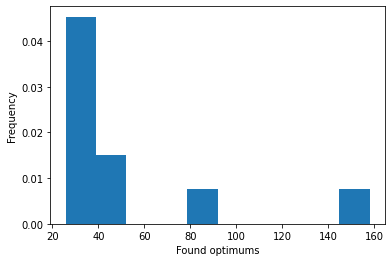

In [ ]:
plt.hist(best_fit, density=True, bins = 10)
plt.ylabel('Frequency')
plt.xlabel('Found optimums');

As a result, we can see that by using best techniques that we found, we still cannot obtain stable good results for 20 iterations. However, it seems, that step by step algortihm is exploring searching space and it has good chances to obtain high results in long-tern distance. Thus, setting of 200 iteration should lead to good results, but it is difficult to check due to the computational limitation of hardware.

# Additional try 

Inspired by: https://arxiv.org/pdf/1712.06567.pdf and https://towardsdatascience.com/reinforcement-learning-without-gradients-evolving-agents-using-genetic-algorithms-8685817d84f

In [6]:
def new_mutation(individual):
    mutation_power = 0.02
    for i in range(len(individual)):
        if i % 2 == 0:
            for j in range(len(individual[i])):
                for k in range(len(individual[i][j])):
                        individual[i][j] += mutation_power * np.random.randn()

    return individual,

In [17]:
def varOr(population, toolbox, lambda_, cxpb, mutpb):
    offspring = []
    for _ in range(lambda_):
        op_choice = random.random()
        if op_choice < cxpb:            # Apply crossover
            ind1, ind2 = list(map(toolbox.clone, random.sample(population, 2)))
            ind1, ind2 = toolbox.mate(ind1, ind2)
            del ind1.fitness.values
            del ind2.fitness.values
            offspring.append(ind1)
            offspring.append(ind2)
        elif op_choice < cxpb + mutpb:  # Apply mutation
            ind = toolbox.clone(random.choice(population))
            ind, = toolbox.mutate(ind)
            del ind.fitness.values
            offspring.append(ind)
        else:                           # Apply reproduction
            offspring.append(toolbox.clone(random.choice(population)))

    return offspring

In [19]:
pop_size = 20
iterations = 20
exp = RL_ga_experiment(input_dim, l1, l2, output_dim, pop_size, iterations)
exp.engine.register("mutate", new_mutation)
exp.mut_prob = 0.6
exp.cxpb = 0.3
exp.engine.register('select', tools.selTournament, tournsize=5)

Intervention to eaMuPlusLambda algorithm: if std is small, we increase probability of mutation

In [23]:
def eaMuPlusLambda(population, toolbox, mu, lambda_, cxpb, mutpb, ngen,
                   stats=None, halloffame=None, verbose=__debug__):
    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)

    record = stats.compile(population) if stats is not None else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)
    cxpb_original = cxpb
    mutpb_original = mutpb

    # Begin the generational process
    for gen in range(1, ngen + 1):
        # Vary the population
        if halloffame is not None:
            for ind in halloffame:
                population.append(toolbox.clone(ind))
        offspring = varOr(population, toolbox, lambda_, cxpb, mutpb)

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        # Update the hall of fame with the generated individuals
        if halloffame is not None:
            halloffame.update(offspring)

        # Select the next generation population
        population[:] = toolbox.select(population + offspring, mu)

        # Update the statistics with the new population
        record = stats.compile(population) if stats is not None else {}
        logbook.record(gen=gen, nevals=len(invalid_ind), **record)
        if verbose:
            print(logbook.stream)
        if record['std'] < 10:
          print('std is very small, set more mutations')
          mutpb = 0.99
          cxpb = 0.001
        else:
          if mutpb != mutpb_original:
            print('set mutpb and cxpb to original values')
            mutpb = mutpb_original
            cxpb = cxpb_original


    return population, logbook


In [24]:
%%time
exp.run()

gen	nevals	min     	max     	avg     	std    
0  	20    	-854.114	-101.075	-403.576	185.527
1  	15    	-333.855	-61.403 	-113.019	67.0517
2  	15    	-101.075	-61.403 	-73.545 	15.7718
3  	13    	-97.8063	-48.1698	-61.8999	9.1392 
std is very small, set more mutations
4  	16    	-61.403 	-48.1698	-53.4722	6.4755 
std is very small, set more mutations
5  	16    	-133.757	-48.1698	-53.1108	18.7244
set mutpb and cxpb to original values
6  	15    	-48.2308	-2.66513	-35.9862	18.7131
7  	15    	-48.1698	-2.66513	-26.9661	20.8162
8  	14    	-48.1698	-2.66513	-7.13754	9.98114
std is very small, set more mutations
9  	16    	-9.98906	28.8261 	1.69236 	11.5086
set mutpb and cxpb to original values
10 	14    	-9.98906	28.8261 	3.26692 	12.8776
11 	13    	-2.66513	28.8261 	11.5059 	15.6667
12 	14    	-2.66513	28.8261 	20.9533 	13.6361
13 	16    	-104.62 	28.8261 	17.0152 	32.4734
14 	12    	28.8261 	28.8261 	28.8261 	7.10543e-15
std is very small, set more mutations
15 	16    	28.7327 	28.8261 	28.

([{'avg': -403.57621977731935,
   'gen': 0,
   'max': -101.07489935783957,
   'min': -854.1135351550389,
   'nevals': 20,
   'std': 185.52676247679776},
  {'avg': -113.01886044349435,
   'gen': 1,
   'max': -61.40303825586088,
   'min': -333.85487317473996,
   'nevals': 15,
   'std': 67.05167265686471},
  {'avg': -73.54501529836196,
   'gen': 2,
   'max': -61.40303825586088,
   'min': -101.07489935783957,
   'nevals': 15,
   'std': 15.771801121299097},
  {'avg': -61.89987777314455,
   'gen': 3,
   'max': -48.169783980979894,
   'min': -97.80633715129663,
   'nevals': 13,
   'std': 9.139204609152408},
  {'avg': -53.472244355261424,
   'gen': 4,
   'max': -48.169783980979894,
   'min': -61.40303825586088,
   'nevals': 16,
   'std': 6.475498488007334},
  {'avg': -53.110821398133226,
   'gen': 5,
   'max': -48.169783980979894,
   'min': -133.75727804916554,
   'nevals': 16,
   'std': 18.72439737938338},
  {'avg': -35.986227514437296,
   'gen': 6,
   'max': -2.665132254913104,
   'min': -48

It seems that this idea did not lead to improvements of results before.